In [86]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from sklearn.externals import joblib
from scipy.sparse import save_npz, vstack, hstack, load_npz

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning

In [43]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10,6)})
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [44]:
# Code Courtesy : AAIC
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)  
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,6))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [45]:
!ls ./train/

train.csv  training_text  training_variants


In [46]:
!head -n 3 ./train/training_variants

ID,Gene,Variation,Class
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2


In [47]:
data_variant = pd.read_csv('./train/training_variants')
data_text = pd.read_csv('./train/training_text', sep='\|\|', engine='python', names=['ID', 'TEXT'], skiprows=1)

In [48]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [49]:
data_text.shape

(3321, 2)

In [50]:
data_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [51]:
data_variant.shape

(3321, 4)

In [52]:
assert(data_text.shape[0] == data_variant.shape[0])

### Text Cleaning

In [53]:
def clean_text(text):
    if text == text: # Best way to check if the value is nan
        text = text.replace(',', '')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('[', '')
        text = text.replace(']', '')
        text = text.replace('.', '')
        text = text.replace('"', '')
        text = text.replace('’', '')
        text = text.replace(':', '')
        text = text.replace('%', '')
        text = text.replace('”', '')
        text = text.replace('’', '')
        text = text.replace('“', '')
        text = text.replace(';', '')
        text = text.lower()
        return text

In [140]:
data_text['TEXT'] = data_text.TEXT.apply(lambda x: clean_text(x))

In [141]:
data_text.head()

,ID,TEXT
0,0,cyclin-dependent kinases cdks regulate a varie...
1,1,abstract background non-small cell lung canc...
2,2,abstract background non-small cell lung canc...
3,3,recent evidence has demonstrated that acquired...
4,4,oncogenic mutations in the monomeric casitas b...


### Merging the two dataframes

In [142]:
data = pd.merge(data_variant, data_text, on='ID')

In [143]:
data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin-dependent kinases cdks regulate a varie...
1,1,CBL,W802*,2,abstract background non-small cell lung canc...
2,2,CBL,Q249E,2,abstract background non-small cell lung canc...
3,3,CBL,N454D,3,recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,oncogenic mutations in the monomeric casitas b...


In [144]:
data.shape

(3321, 5)

### Checkpoint 1

In [145]:
data.to_csv('./train/train.csv', index=False)

### Filling the NaN values

In [54]:
data = pd.read_csv('./train/train.csv')

In [55]:
null_ids = data[data.isnull().any(axis=1)].ID

In [56]:
fill = data.loc[data.ID.isin(null_ids), ['Gene']].Gene + ' ' + data.loc[data.ID.isin(null_ids), ['Variation']].Variation

In [57]:
data.loc[data.ID.isin(null_ids), 'TEXT'] = fill

In [58]:
data.loc[data.ID.isin(null_ids),]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


### Splitting the data into train-cv-test

In [59]:
y = data['Class'].values

In [60]:
y

array([1, 2, 2, ..., 1, 4, 4])

In [61]:
data.drop('Class', axis=1, inplace=True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [154]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [155]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_cv.shape[0] == y_cv.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

### Checkpoint 2

In [29]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [156]:
X_train.to_csv('./dataset/train.csv', index=False)
np.save('./dataset/train_label.npy', y_train)

X_cv.to_csv('./dataset/cv.csv', index=False)
np.save('./dataset/cv_label.npy', y_cv)

X_test.to_csv('./dataset/test.csv', index=False)
np.save('./dataset/test_label.npy', y_test)

In [63]:
X_train = pd.read_csv('./dataset/train.csv')
X_cv = pd.read_csv('./dataset/cv.csv')
X_test = pd.read_csv('./dataset/test.csv')
y_train = np.load('./dataset/train_label.npy')
y_cv = np.load('./dataset/cv_label.npy')
y_test = np.load('./dataset/test_label.npy')

### Distribution of class labels in datasets

In [64]:
train = X_train.copy()
train['class'] = y_train

cv = X_cv.copy()
cv['class'] = y_cv

test = X_test.copy()
test['class'] = y_test

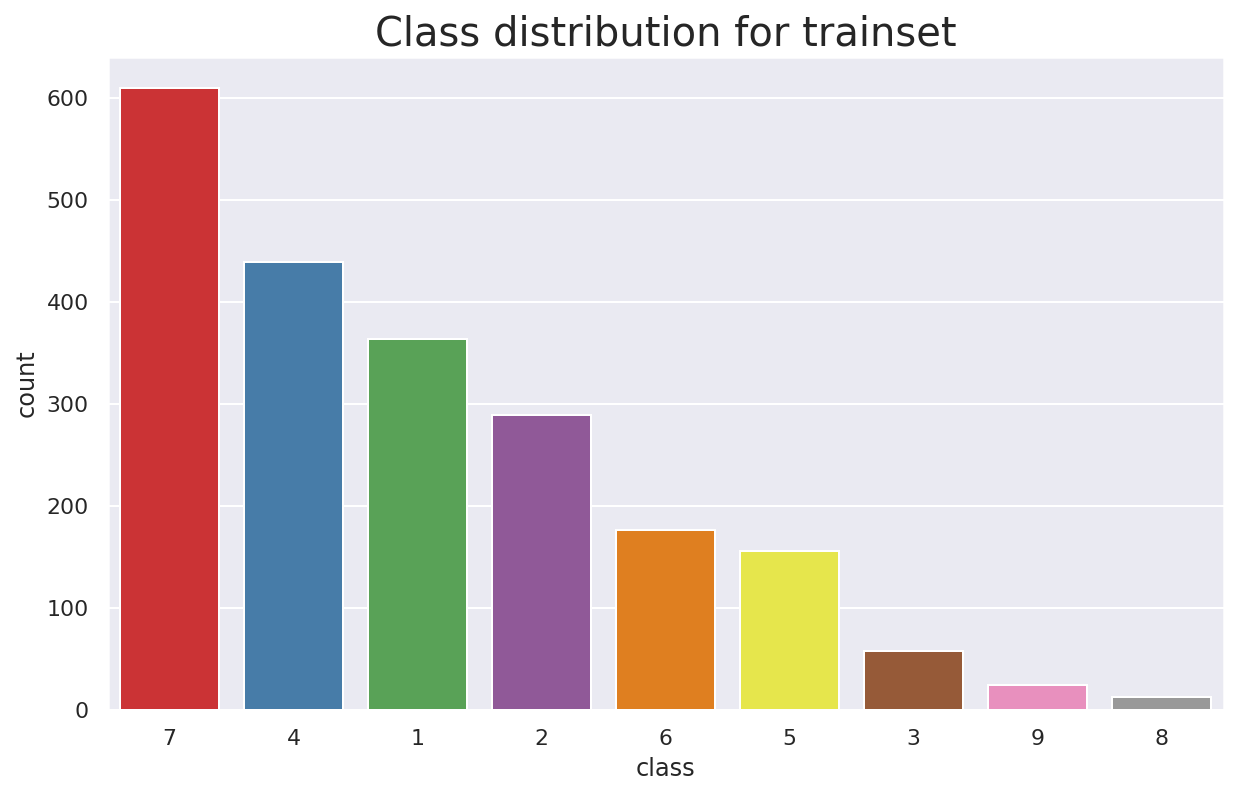

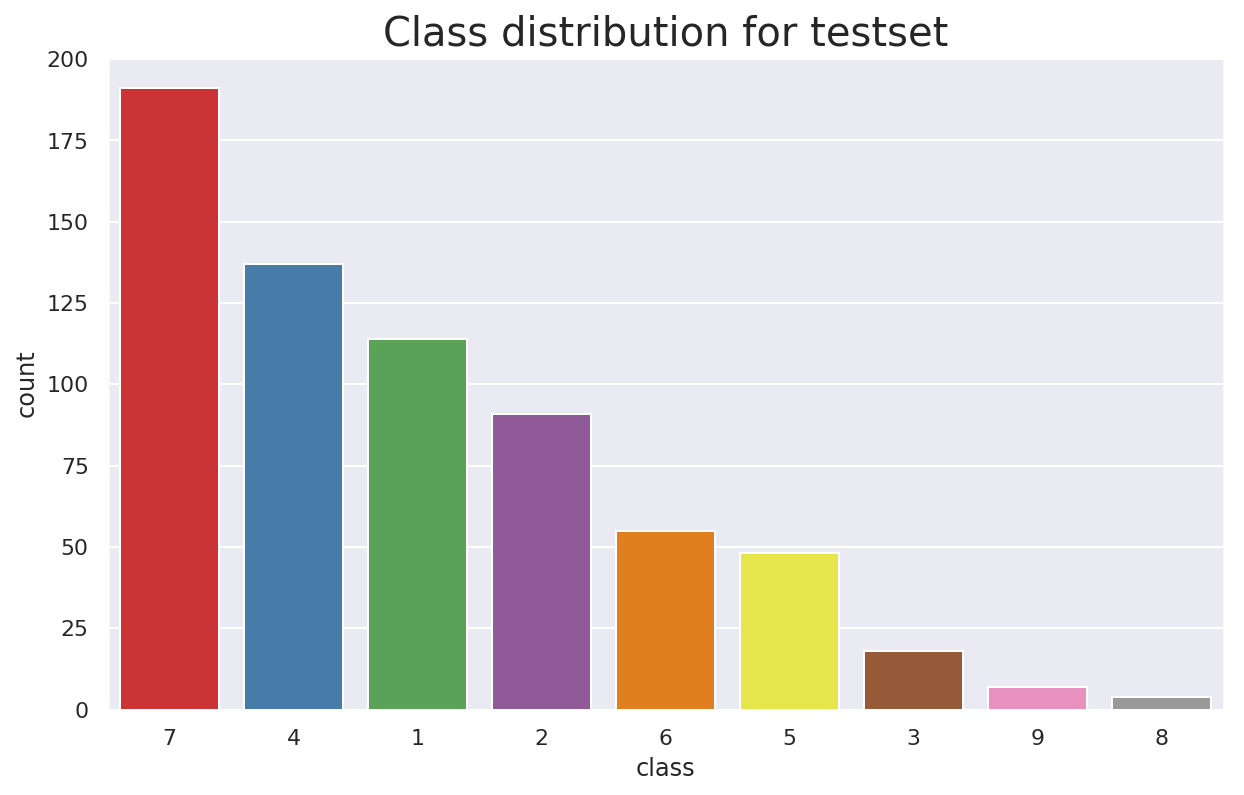

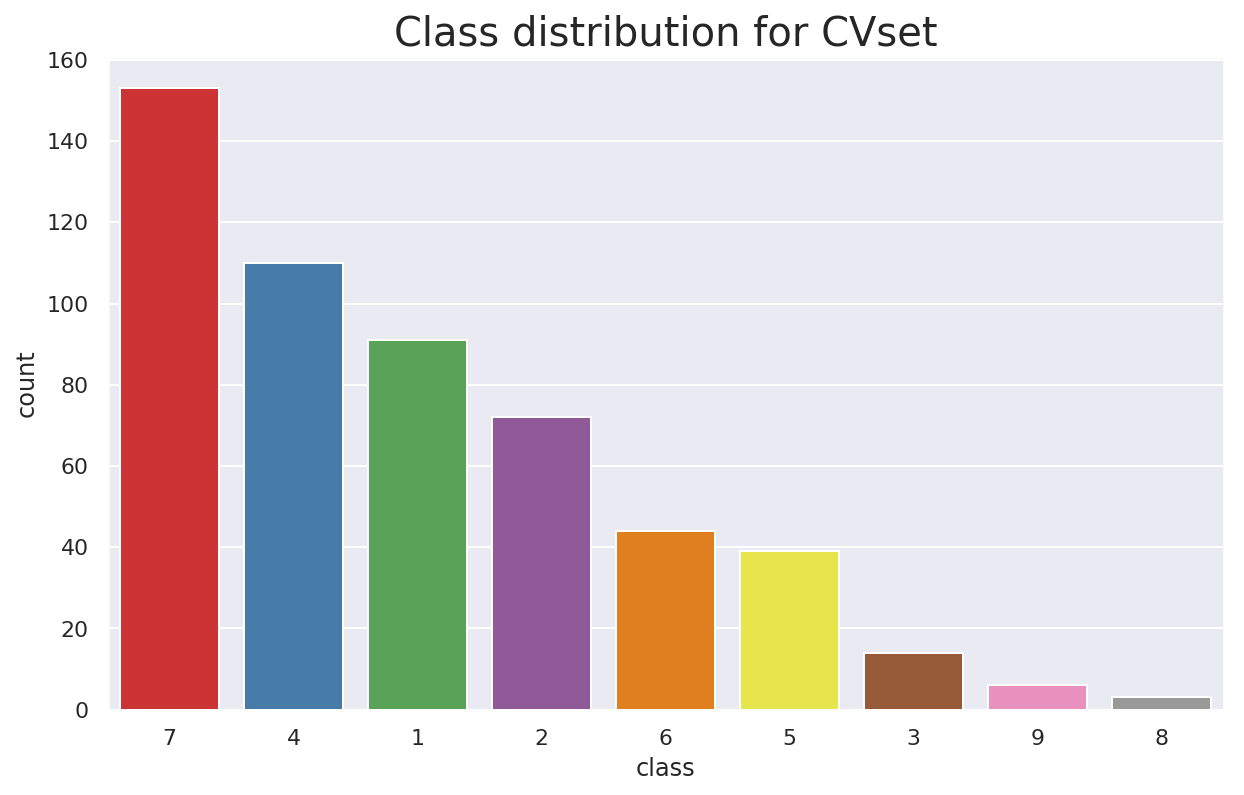

In [65]:
sns.countplot(x='class', data=train, palette='Set1',
             order=train['class'].value_counts().index);
plt.title('Class distribution for trainset', fontsize=20);
plt.show()
sns.countplot(x='class', data=test, palette='Set1',
             order=test['class'].value_counts().index);
plt.title('Class distribution for testset', fontsize=20);
plt.show()
sns.countplot(x='class', data=cv, palette='Set1',
             order=cv['class'].value_counts().index);
plt.title('Class distribution for CVset', fontsize=20);
plt.show()

### Random Model

In [159]:
np.random.seed(42)

In [160]:
def create_random_model(X, y_true):
    n = X.shape[0]
    rp = np.random.rand(n, 9)
    y_pred = rp / np.sum(rp, axis=1).reshape(n, -1)
    return y_pred, log_loss(y_true, y_pred)

In [161]:
print('Train log-loss of Random Model: ' , create_random_model(X_train, y_train)[1])
print('CV log-loss of Random Model: ' , create_random_model(X_cv, y_cv)[1])
test_preds, test_ll = create_random_model(X_test, y_test)
print('Test log-loss of Random Model: ' , test_ll)

Train log-loss of Random Model:  2.4750615327705483
CV log-loss of Random Model:  2.4811482147268307
Test log-loss of Random Model:  2.4943753407000915


In [162]:
y_test_pred = np.argmax(test_preds, axis=1) + 1

-------------------- Confusion matrix --------------------


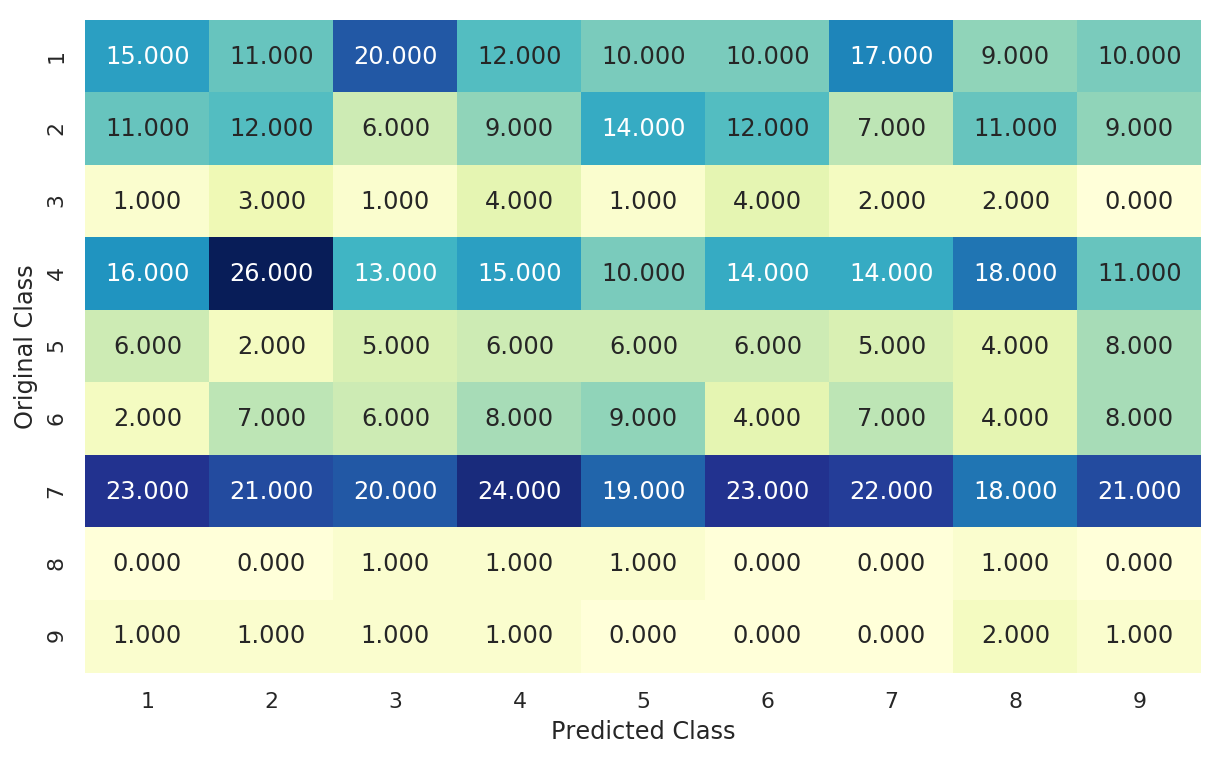

-------------------- Precision matrix (Columm Sum=1) --------------------


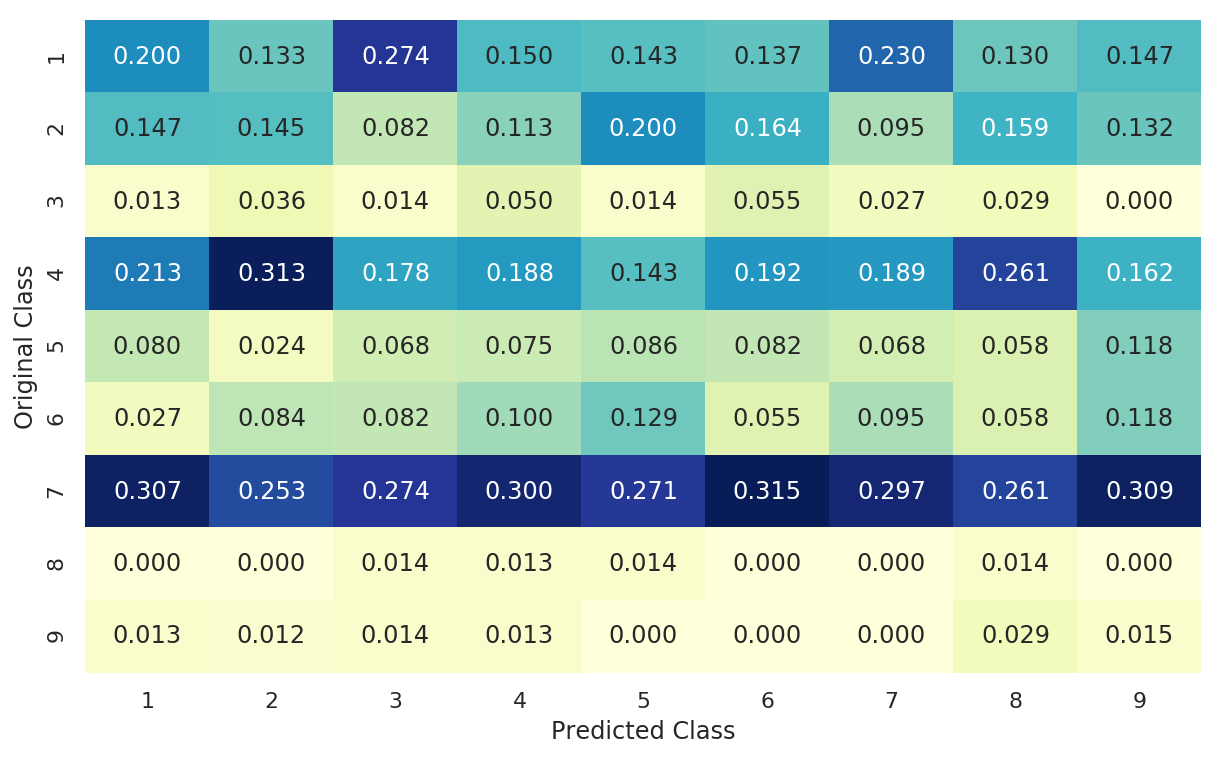

-------------------- Recall matrix (Row sum=1) --------------------


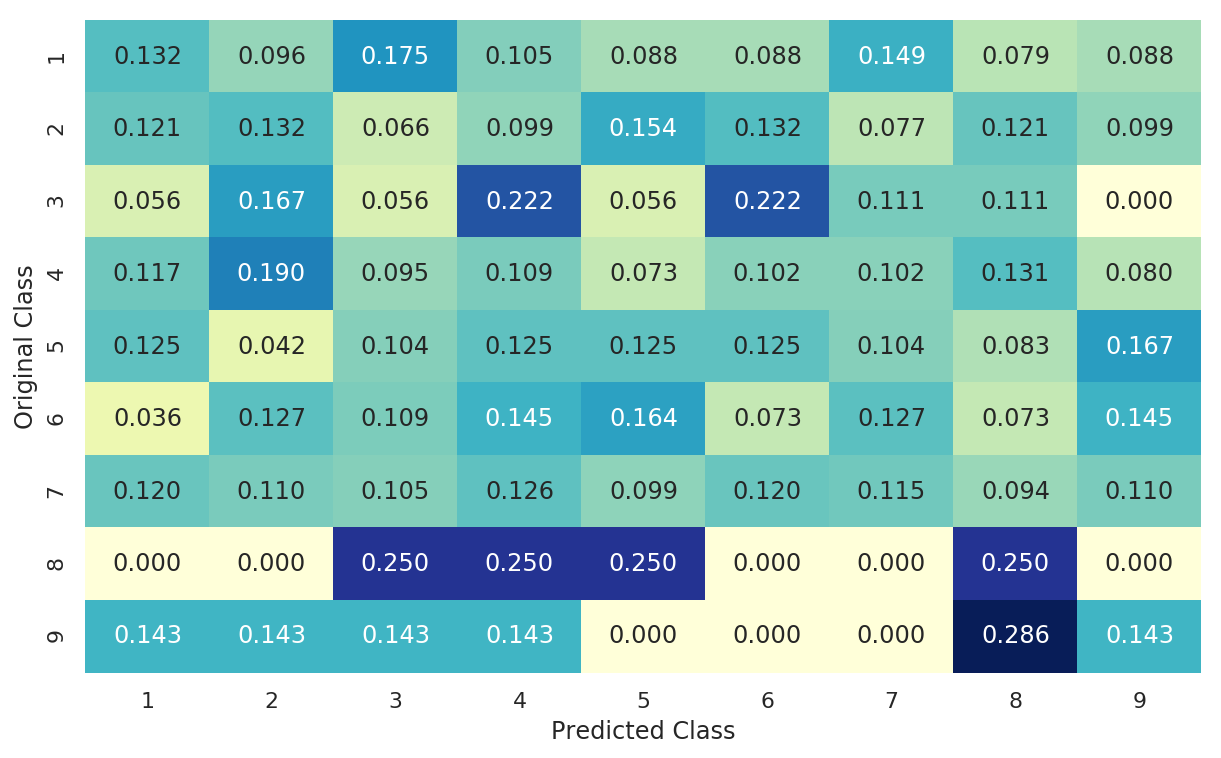

In [163]:
plot_confusion_matrix(y_test, y_test_pred)

### Response Coding of `X_train` for a feature with Laplace Smoothing

In [66]:
def get_response_coding_for(feature, alpha=1):
    counts = train[feature].value_counts()
    feature_dict = defaultdict(list)
    for each in train[feature].unique():
        for each_class in range(1, 10):
            match_count = train[(train['class'] == each_class) & 
                            (train[feature] == each)].shape[0]
            ## Calculate the probability with laplace smoothing
            feature_dict[each].append((match_count + alpha * 10) / (counts[each] + alpha * 90))
    return feature_dict

In [67]:
%time gene_coding = get_response_coding_for('Gene')
%time variation_coding = get_response_coding_for('Variation')

CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 2.03 s
CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 17.9 s


In [68]:
gene_coding = dict(gene_coding)
variation_coding = dict(variation_coding)

In [69]:
assert(len(gene_coding.keys()) == len(train.Gene.unique()))

In [70]:
assert(len(variation_coding.keys()) == len(train.Variation.unique()))

### Featurizing `GENE`

##### Gene Response coding

In [71]:
def featurize_gene(gene):
    try:
        return gene_coding[gene]
    except KeyError:
        return [1/9] * 9

In [72]:
X_train_responseCoding_gene = np.array(X_train.Gene.apply(featurize_gene).tolist())
X_cv_responseCoding_gene = np.array(X_cv.Gene.apply(featurize_gene).tolist())
X_test_responseCoding_gene = np.array(X_test.Gene.apply(featurize_gene).tolist())

In [73]:
assert(X_train_responseCoding_gene.shape[0] == X_train.shape[0])
assert(X_cv_responseCoding_gene.shape[0] == X_cv.shape[0])
assert(X_test_responseCoding_gene.shape[0] == X_test.shape[0])

##### Gene OneHotEncoding

In [9]:
vect = CountVectorizer(binary=True)
vect.fit(X_train.Gene)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
X_train_oneHotEncoding_gene = vect.transform(X_train.Gene)
X_cv_oneHotEncoding_gene = vect.transform(X_cv.Gene)
X_test_oneHotEncoding_gene = vect.transform(X_test.Gene)

In [11]:
assert(X_train_oneHotEncoding_gene.shape[1] == X_cv_oneHotEncoding_gene.shape[1] == X_test_oneHotEncoding_gene.shape[1])

In [12]:
assert(X_train_oneHotEncoding_gene.shape[0] == X_train.shape[0])
assert(X_test_oneHotEncoding_gene.shape[0] == X_test.shape[0])
assert(X_cv_oneHotEncoding_gene.shape[0] == X_cv.shape[0])

### Featurizing `Variations`

##### Variations Response coding

In [74]:
def featurize_variations(variation):
    try:
        return variation_coding[variation]
    except KeyError:
        return [1/9] * 9

In [75]:
X_train_responseCoding_variation = np.array(X_train.Variation.apply(featurize_variations).tolist())
X_cv_responseCoding_variation = np.array(X_cv.Variation.apply(featurize_variations).tolist())
X_test_responseCoding_variation = np.array(X_test.Variation.apply(featurize_variations).tolist())

In [76]:
assert(X_train_responseCoding_variation.shape[0] == X_train.shape[0])
assert(X_cv_responseCoding_variation.shape[0] == X_cv.shape[0])
assert(X_test_responseCoding_variation.shape[0] == X_test.shape[0])

##### Variations OneHot encoding

In [13]:
vect = CountVectorizer(binary=True)
vect.fit(X_train.Variation)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
X_train_oneHotEncoding_variation = vect.transform(X_train.Variation)
X_cv_oneHotEncoding_variation = vect.transform(X_cv.Variation)
X_test_oneHotEncoding_variation = vect.transform(X_test.Variation)

In [15]:
assert(X_train_oneHotEncoding_variation.shape[1] == 
       X_cv_oneHotEncoding_variation.shape[1] == 
       X_test_oneHotEncoding_variation.shape[1])

In [16]:
assert(X_train_oneHotEncoding_variation.shape[0] == X_train.shape[0])
assert(X_test_oneHotEncoding_variation.shape[0] == X_test.shape[0])
assert(X_cv_oneHotEncoding_variation.shape[0] == X_cv.shape[0])

### Featurizing `Text`

In [6]:
STOPWORDS = stopwords.words('english')

In [7]:
## Adding some domain specific stopwords
STOPWORDS.extend(['fig', 'whereas', 'however', 
                  'also', 'figure', 'known', 'table'])

##### Construct the token count for each class label

In [193]:
dict_list = []
for cl in range(1, 10):
    corpus = train[train['class'] == cl].TEXT
    count_dict = defaultdict(int)
    for doc in corpus:
        for token in word_tokenize(doc):
            if token not in STOPWORDS:
                count_dict[token] += 1
    dict_list.append(count_dict)

##### Construct the token count for all class labels


In [196]:
total_dict = defaultdict(int)
corpus = train.TEXT
for doc in corpus:
    for token in word_tokenize(doc):
        if token not in STOPWORDS:
            total_dict[token] += 1

In [199]:
joblib.dump(dict_list, './dataset/dict_list')
joblib.dump(total_dict, './dataset/total_dict')

['./dataset/total_dict']

In [200]:
!ls ./dataset/

cv.csv	      dict_list  test_label.npy  train.csv
cv_label.npy  test.csv	 total_dict	 train_label.npy


##### TEXT Response coding

In [206]:
import math

In [207]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                if word not in STOPWORDS:
                    sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [208]:
%%time
X_train_text_responseCoding = get_text_responsecoding(X_train)
X_test_text_responseCoding = get_text_responsecoding(X_test)
X_cv_text_responseCoding = get_text_responsecoding(X_cv)

CPU times: user 13min 50s, sys: 136 ms, total: 13min 50s
Wall time: 13min 50s


In [210]:
np.save('./dataset/X_train_text_responseCoding.npy', X_train_text_responseCoding)
np.save('./dataset/X_test_text_responseCoding.npy', X_test_text_responseCoding)
np.save('./dataset/X_cv_text_responseCoding.npy', X_cv_text_responseCoding)

##### TEXT CountVectoriser (1, 2 gram)

In [ ]:
vect = CountVectorizer(min_df=3, ngram_range=(1, 2), stop_words=STOPWORDS)
vect.fit(X_train.TEXT)

In [213]:
X_train_text_countVectorizer = vect.transform(X_train.TEXT)
X_test_text_countVectorizer = vect.transform(X_test.TEXT)
X_cv_text_countVectorizer = vect.transform(X_cv.TEXT)

In [231]:
X_train_text_countVectorizer.shape

(2124, 784749)

In [217]:
assert(X_train_text_countVectorizer.shape[1] == 
       X_test_text_countVectorizer.shape[1] == 
       X_cv_text_countVectorizer.shape[1])

In [219]:
save_npz('./dataset/X_train_text_countVectorizer.npz', X_train_text_countVectorizer)
save_npz('./dataset/X_test_text_countVectorizer.npz', X_test_text_countVectorizer)
save_npz('./dataset/X_cv_text_countVectorizer.npz', X_cv_text_countVectorizer)

##### TEXT TFIDFVectorizer (1 gram for top 1000 words)

In [224]:
tfidf = TfidfVectorizer(stop_words=STOPWORDS, max_features=1000)
tfidf.fit(X_train.TEXT)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...on', "won't", 'wouldn', "wouldn't", 'fig', 'whereas', 'however', 'also', 'figure', 'known', 'table'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [225]:
X_train_text_tfidfVectorizer = tfidf.transform(X_train.TEXT)
X_test_text_tfidfVectorizer = tfidf.transform(X_test.TEXT)
X_cv_text_tfidfVectorizer = tfidf.transform(X_cv.TEXT)

In [226]:
X_train_text_tfidfVectorizer.shape

(2124, 1000)

In [232]:
assert(X_train_text_tfidfVectorizer.shape[1] == 
       X_test_text_tfidfVectorizer.shape[1] == 
       X_cv_text_tfidfVectorizer.shape[1])

##### TEXT TFIDFVectorizer (1, 2 gram)

In [228]:
tfidf = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(1, 2), min_df=3)
tfidf.fit(X_train.TEXT)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...on', "won't", 'wouldn', "wouldn't", 'fig', 'whereas', 'however', 'also', 'figure', 'known', 'table'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [229]:
X_train_text_tfidfVectorizer2 = tfidf.transform(X_train.TEXT)
X_test_text_tfidfVectorizer2 = tfidf.transform(X_test.TEXT)
X_cv_text_tfidfVectorizer2 = tfidf.transform(X_cv.TEXT)

In [230]:
X_train_text_tfidfVectorizer2.shape

(2124, 784749)

In [233]:
assert(X_train_text_tfidfVectorizer2.shape[1] == 
       X_test_text_tfidfVectorizer2.shape[1] == 
       X_cv_text_tfidfVectorizer2.shape[1])

In [234]:
save_npz('./dataset/X_train_text_tfidfVectorizer2.npz', X_train_text_tfidfVectorizer2)
save_npz('./dataset/X_test_text_tfidfVectorizer2.npz', X_test_text_tfidfVectorizer2)
save_npz('./dataset/X_cv_text_tfidfVectorizer2.npz', X_cv_text_tfidfVectorizer2)

## Modelling

#### Stack the datasets (OneHotEncoding(Gene, Variation), 1 gram TFIDF + 1,2 gram CountVectorizer)

In [ ]:
train_v1 = hstack((X_train_oneHotEncoding_gene, X_train_oneHotEncoding_variation, 
       X_train_text_tfidfVectorizer, X_train_text_countVectorizer))

cv_v1 = hstack((X_cv_oneHotEncoding_gene, X_cv_oneHotEncoding_variation, 
       X_cv_text_tfidfVectorizer, X_cv_text_countVectorizer))

test_v1 = hstack((X_test_oneHotEncoding_gene, X_test_oneHotEncoding_variation, 
       X_test_text_tfidfVectorizer, X_test_text_countVectorizer))

In [252]:
assert(train_v1.shape[0] == y_train.shape[0])
assert(cv_v1.shape[0] == y_cv.shape[0])
assert(test_v1.shape[0] == y_test.shape[0])

In [258]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', 
                        loss='log', random_state=42, n_jobs=16, max_iter=100)
    clf.fit(train_v1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_v1, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_v1)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.8304997567764278
for alpha = 1e-05
Log Loss : 1.3310415374045332
for alpha = 0.0001
Log Loss : 1.3095961613325962
for alpha = 0.001
Log Loss : 1.3083975083791255
for alpha = 0.01
Log Loss : 1.297270012665485
for alpha = 0.1
Log Loss : 1.2650404062491212
for alpha = 1
Log Loss : 1.1483740156655924
for alpha = 10
Log Loss : 1.1727450094567051
for alpha = 100
Log Loss : 1.3388799051506275


In [260]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], 
                    penalty='l2', loss='log', random_state=42, max_iter=100, n_jobs=16)
clf.fit(train_v1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_v1, y_train)

predict_y = sig_clf.predict_proba(train_v1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, 
                                                                                          labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_v1)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, 
                                                                                                     labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_v1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, 
                                                                                         labels=clf.classes_, eps=1e-15))

For values of best alpha =  1 The train log loss is: 0.8284182847722845
For values of best alpha =  1 The cross validation log loss is: 1.1483740156655924
For values of best alpha =  1 The test log loss is: 1.1492486543062301


In [284]:
params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}

estimator = LogisticRegression(random_state=42, multi_class='multinomial', 
                               solver='saga', penalty='l1')

grid = GridSearchCV(estimator=estimator,
                param_grid=params,
                scoring='neg_log_loss',
#                 refit='neg_log_loss', # Because we are using multiple evaluation metrics
                cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                return_train_score=True,
                verbose=2,
                n_jobs=16)

In [ ]:
grid.fit(train_v1, y_train)

In [344]:
predict_y = grid.best_estimator_.predict_proba(train_v1)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = grid.best_estimator_.predict_proba(cv_v1)
print("The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = grid.best_estimator_.predict_proba(test_v1)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The train log loss is: 0.7280848671260255
The cv log loss is: 1.1713509363539854
The test log loss is: 1.091204570906913


Number of mis-classified points : 0.3518796992481203
-------------------- Confusion matrix --------------------


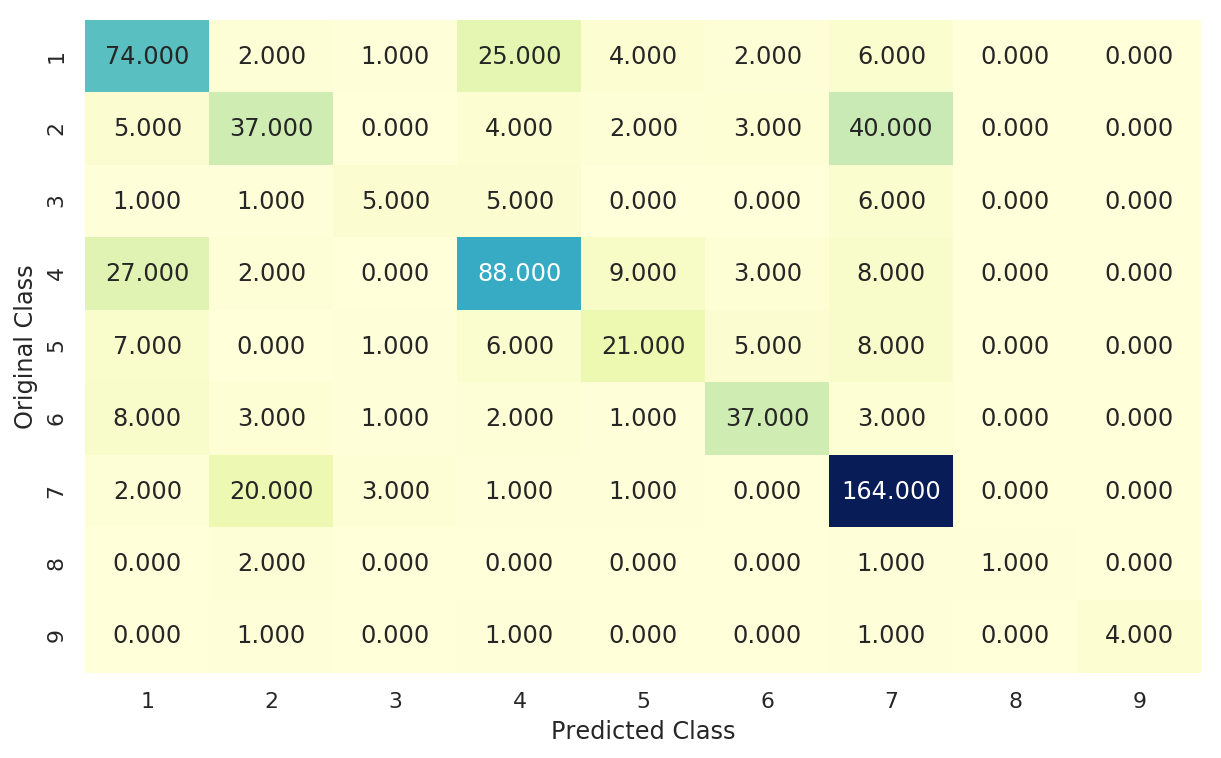

-------------------- Precision matrix (Columm Sum=1) --------------------


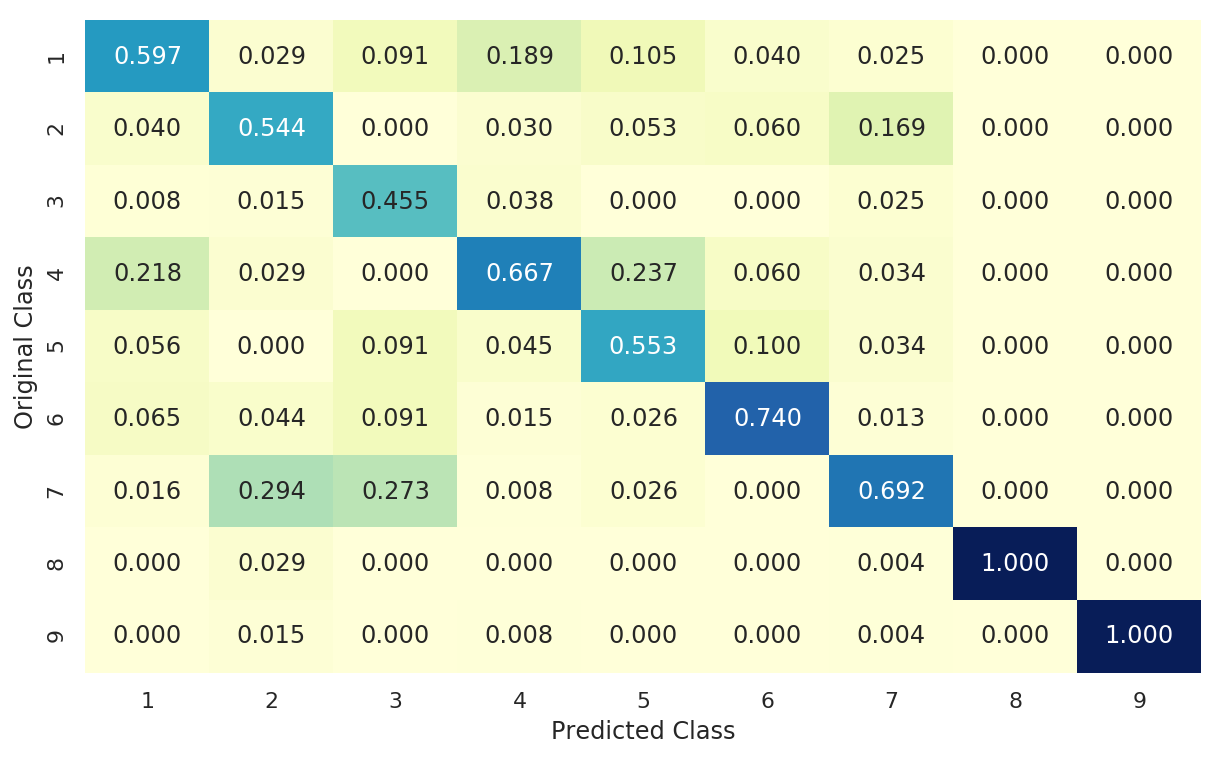

-------------------- Recall matrix (Row sum=1) --------------------


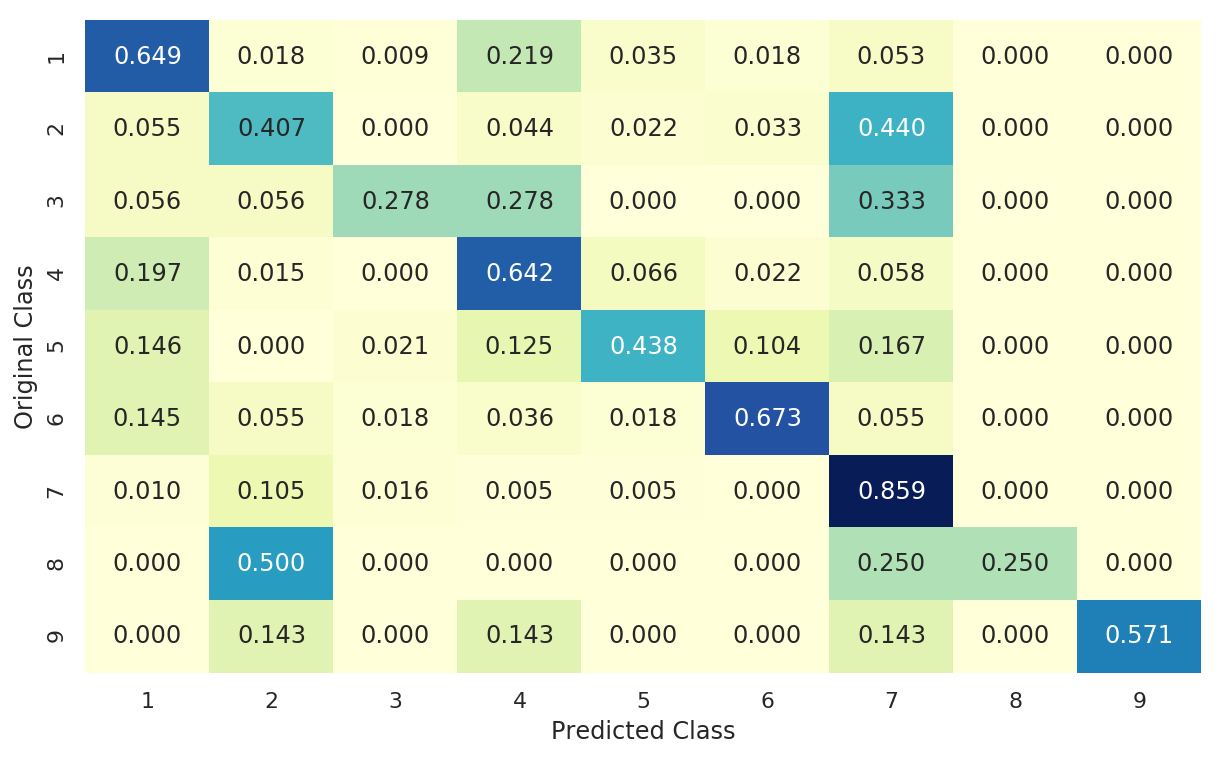

In [345]:
predict_y = grid.best_estimator_.predict(test_v1)
print("Number of mis-classified points :", np.count_nonzero((predict_y- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, predict_y)

#### Stack the datasets (OneHotEncoding(Gene, Variation), 1,2,3 gram TFIDF (20000 features))

In [18]:
tfidf = TfidfVectorizer(min_df=5, max_features=20000, strip_accents='unicode',
                        analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3),
                        sublinear_tf=True, stop_words = STOPWORDS)
tfidf.fit(X_train.TEXT)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...on', "won't", 'wouldn', "wouldn't", 'fig', 'whereas', 'however', 'also', 'figure', 'known', 'table'],
        strip_accents='unicode', sublinear_tf=True, token_pattern='\\w+',
        tokenizer=None, use_idf=True, vocabulary=None)

In [19]:
X_train_text_tfidfVectorizer3 = tfidf.transform(X_train.TEXT)
X_cv_text_tfidfVectorizer3 = tfidf.transform(X_cv.TEXT)
X_test_text_tfidfVectorizer3 = tfidf.transform(X_test.TEXT)

In [20]:
X_train_text_tfidfVectorizer3.shape

(2124, 20000)

In [21]:
train_v1 = hstack((X_train_oneHotEncoding_gene, X_train_oneHotEncoding_variation, 
       X_train_text_tfidfVectorizer3))

cv_v1 = hstack((X_cv_oneHotEncoding_gene, X_cv_oneHotEncoding_variation, 
       X_cv_text_tfidfVectorizer3))

test_v1 = hstack((X_test_oneHotEncoding_gene, X_test_oneHotEncoding_variation, 
       X_test_text_tfidfVectorizer3))

In [22]:
train_v1.shape

(2124, 22182)

In [23]:
cv_v1.shape

(532, 22182)

In [89]:
train = vstack((train_v1, cv_v1), format='csr')

train_y = np.hstack((y_train, y_cv))

In [36]:
assert(train.shape[0] == train_y.shape[0])

In [37]:
assert(train.shape[0] == (train_v1.shape[0] + cv_v1.shape[0]))

In [ ]:
# y_test_pred = np.zeros((X_test.shape[0], 9))

alphas = [10 ** x for x in range(-6, 3)]
LL = defaultdict(list)
for alpha in alphas:
    n_folds = 5
    kf = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
    fold = 0
    clf = SGDClassifier(class_weight='balanced', alpha=alpha, max_iter=100,
                    penalty='l2', loss='log', random_state=42, n_jobs=16)
    for train_index, test_index in kf.split(train, train_y):
        fold += 1
        X_tr, X_vl    = train[train_index], train[test_index]
        y_tr, y_vl    = train_y[train_index], train_y[test_index]
        print("Fold", fold, X_tr.shape, X_vl.shape)
        clf.fit(X_tr, y_tr)
        
        p_train = clf.predict_proba(X_tr)
        p_valid = clf.predict_proba(X_vl)
        
        print(log_loss(y_tr, p_train))
        print(log_loss(y_vl, p_valid))
        LL[alpha].append(log_loss(y_vl, p_valid))

In [52]:
pd.DataFrame.from_dict(LL).mean(axis=0)

0.000001      1.872871
0.000010      1.047271
0.000100      0.928340
0.001000      1.193285
0.010000      1.758546
0.100000      2.112511
1.000000      2.187016
10.000000     2.196120
100.000000    2.197084
dtype: float64

In [ ]:
C = [10 ** x for x in range(-6, 5)]
LL = defaultdict(list)
for c in C:
    n_folds = 5
    kf = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
    fold = 0
    clf = LogisticRegression(class_weight='balanced', C=c, max_iter=1000,
                    penalty='l2', solver='saga', random_state=42, n_jobs=16)
    print('-' * 40)
    print('C = ', c)
    print('-' * 40)
    for train_index, test_index in kf.split(train, train_y):
        fold += 1
        X_tr, X_vl    = train[train_index], train[test_index]
        y_tr, y_vl    = train_y[train_index], train_y[test_index]
        print("Fold", fold, X_tr.shape, X_vl.shape)
        clf.fit(X_tr, y_tr)
        
        p_train = clf.predict_proba(X_tr)
        p_valid = clf.predict_proba(X_vl)
        
        print()
        print('Train Log-loss', log_loss(y_tr, p_train))
        print('Validation log-loss', log_loss(y_vl, p_valid))
        print()
        LL[c].append(log_loss(y_vl, p_valid))

In [388]:
pd.DataFrame.from_dict(LL).mean(axis=0)

0.000001        2.197163
0.000010        2.196883
0.000100        2.193756
0.001000        2.153946
0.010000        1.978744
0.100000        1.687014
1.000000        1.111013
10.000000       0.925289
100.000000      1.070109
1000.000000     1.428871
10000.000000    1.558207
dtype: float64

In [ ]:
C = [x for x in range(1, 11)]
LL = defaultdict(list)
for c in C:
    n_folds = 5
    kf = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
    fold = 0
    clf = LogisticRegression(class_weight='balanced', C=c, max_iter=1000,
                    penalty='l2', solver='saga', random_state=42, n_jobs=16)
    print('-' * 40)
    print('C = ', c)
    print('-' * 40)
    for train_index, test_index in kf.split(train, train_y):
        fold += 1
        X_tr, X_vl    = train[train_index], train[test_index]
        y_tr, y_vl    = train_y[train_index], train_y[test_index]
        print("Fold", fold, X_tr.shape, X_vl.shape)
        clf.fit(X_tr, y_tr)
        
        p_train = clf.predict_proba(X_tr)
        p_valid = clf.predict_proba(X_vl)
        
        print()
        print('Train Log-loss', log_loss(y_tr, p_train))
        print('Validation log-loss', log_loss(y_vl, p_valid))
        print()
        LL[c].append(log_loss(y_vl, p_valid))

In [55]:
pd.DataFrame.from_dict(LL).mean(axis=0).sort_values()

10    0.925289
8     0.928723
9     0.929353
6     0.932104
7     0.937117
5     0.956478
4     0.958347
3     0.977572
2     1.024161
1     1.111013
dtype: float64

#### For C=10

In [32]:
clf = LogisticRegression(class_weight='balanced', C=10, max_iter=1000,
                    penalty='l2', solver='saga', random_state=42, n_jobs=16)
clf.fit(train_v1, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=16, penalty='l2', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [38]:
predict_y = clf.predict_proba(train_v1)
print("The Train log loss is:",log_loss(y_train, predict_y))
predict_y = clf.predict_proba(cv_v1)
print("The CV log loss is:",log_loss(y_cv, predict_y))
# predict_y = clf.predict_proba(test_v1)
# print("The Test log loss is:",log_loss(y_test, predict_y))

The Train log loss is: 0.23691066561896426
The CV log loss is: 0.9308042897471324


The Test log loss is: 0.8864847254718247
Number of mis-classified points : 0.3007518796992481
-------------------- Confusion matrix --------------------


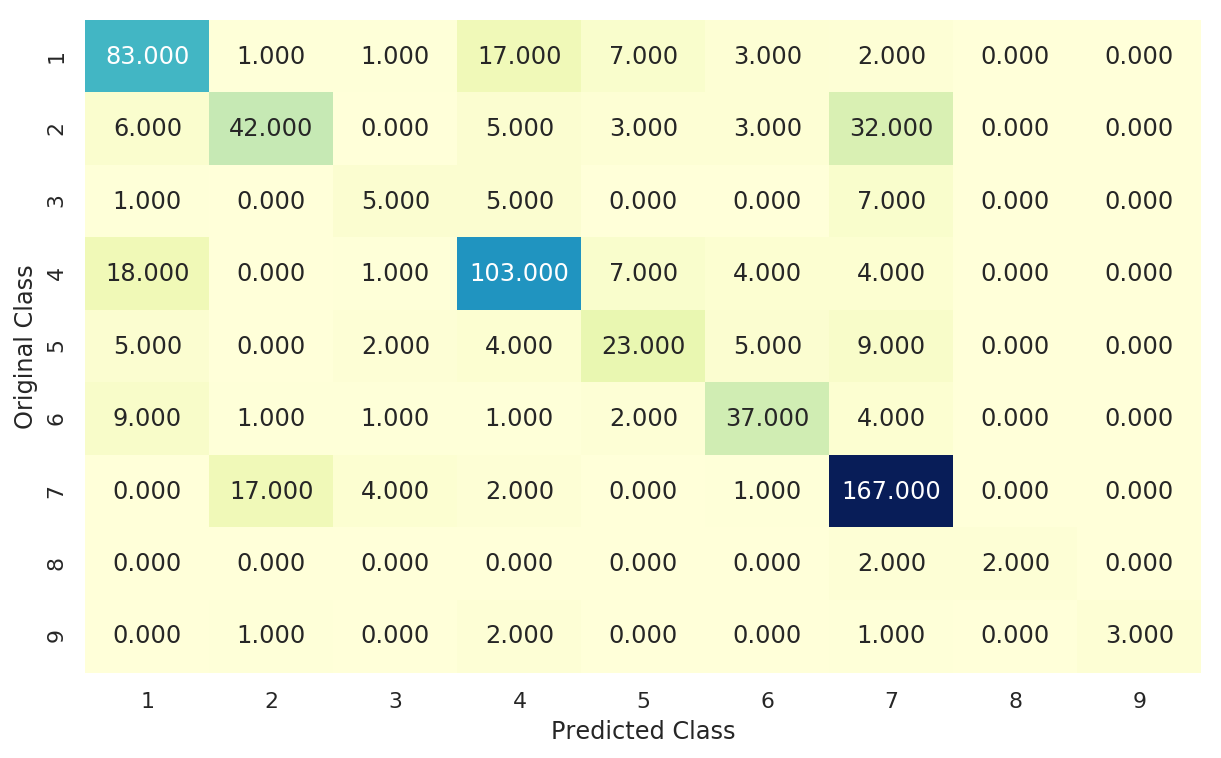

-------------------- Precision matrix (Columm Sum=1) --------------------


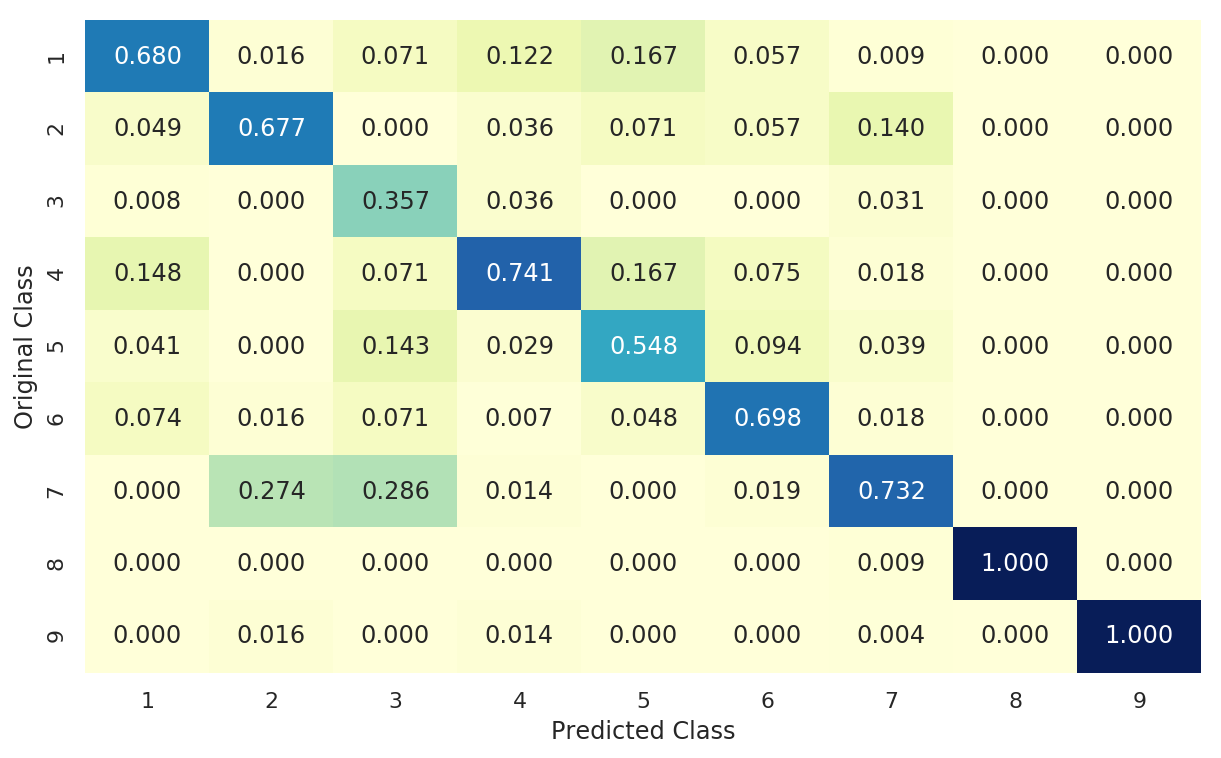

-------------------- Recall matrix (Row sum=1) --------------------


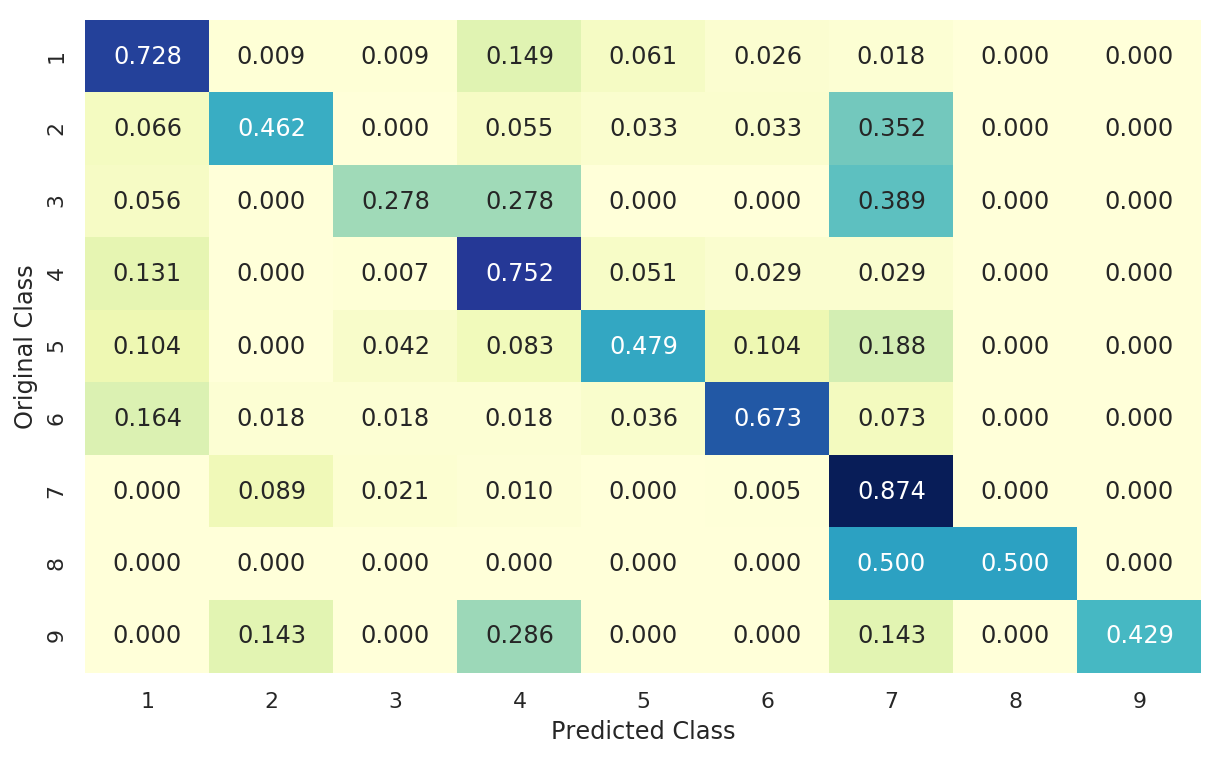

In [39]:
predict_y = clf.predict_proba(test_v1)
print("The Test log loss is:",log_loss(y_test, predict_y))
predict_y = clf.predict(test_v1)
print("Number of mis-classified points :", np.count_nonzero((predict_y- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, predict_y)

#### Brute Ensemble model with (Response coding for gene, variation, text, text binary CountVectorizer) and previous best model 

In [77]:
X_train_text_responseCoding =np.load('./dataset/X_train_text_responseCoding.npy')
X_cv_text_responseCoding =np.load('./dataset/X_cv_text_responseCoding.npy')
X_test_text_responseCoding =np.load('./dataset/X_test_text_responseCoding.npy')

In [83]:
X_train_responseCoding_gene.shape

(2124, 9)

In [102]:
vect = CountVectorizer(min_df=5, binary=True, stop_words=STOPWORDS, max_features=100)
vect.fit(X_train.TEXT)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=5,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...on', "won't", 'wouldn', "wouldn't", 'fig', 'whereas', 'however', 'also', 'figure', 'known', 'table'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [105]:
X_train_text_countBinary = vect.transform(X_train.TEXT).toarray()
X_cv_text_countBinary = vect.transform(X_cv.TEXT).toarray()
X_test_text_countBinary = vect.transform(X_test.TEXT).toarray()

In [106]:
train_v1 = np.hstack((X_train_responseCoding_gene,
                      X_train_responseCoding_variation,
                      X_train_text_responseCoding,
                      X_train_text_countBinary))

cv_v1 = np.hstack((X_cv_responseCoding_gene,
                   X_cv_responseCoding_variation,
                   X_cv_text_responseCoding,
                   X_cv_text_countBinary))

test_v1 = np.hstack((X_test_responseCoding_gene,
                     X_test_responseCoding_variation,
                     X_test_text_responseCoding,
                     X_test_text_countBinary))

In [107]:
params = {
    'max_depth': [2, 3, 5, 10],
    'n_estimators': [100, 300, 500, 1000]
}

estimator = RandomForestClassifier(random_state=42)

grid = GridSearchCV(estimator=estimator,
                param_grid=params,
                scoring='neg_log_loss',
#                 refit='neg_log_loss', # Because we are using multiple evaluation metrics
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                return_train_score=True,
                verbose=1,
                n_jobs=16)

In [108]:
train = vstack((train_v1, cv_v1), format='csr')
train_y = np.hstack((y_train, y_cv))

In [109]:
train.shape

(2656, 127)

In [110]:
train_y.shape

(2656,)

In [111]:
grid.fit(train, train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:   29.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=16,
       param_grid={'max_depth': [2, 3, 5, 10], 'n_estimators': [100, 300, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [112]:
predict_y = grid.best_estimator_.predict_proba(train_v1)
print("The Train log loss is:",log_loss(y_train, predict_y))
predict_y = grid.best_estimator_.predict_proba(cv_v1)
print("The CV log loss is:",log_loss(y_cv, predict_y))
predict_y = grid.best_estimator_.predict_proba(test_v1)
print("The Test log loss is:",log_loss(y_test, predict_y))

The Train log loss is: 0.1627229376300594
The CV log loss is: 0.6504497086752777
The Test log loss is: 1.0049755475591882


In [115]:
test_v1_1 = hstack((X_test_oneHotEncoding_gene, 
                    X_test_oneHotEncoding_variation, 
                    X_test_text_tfidfVectorizer3))

test_v1_2 = np.hstack((X_test_responseCoding_gene,
                     X_test_responseCoding_variation,
                     X_test_text_responseCoding,
                     X_test_text_countBinary))

In [140]:
pred1 = clf.predict_proba(test_v1_1)
pred2 = grid.best_estimator_.predict_proba(test_v1_2)

In [142]:
scores = {}
for each in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    pred = ((each * pred1) + ((1 - each) * pred2)) / 2
    scores[each] = log_loss(y_test, pred)

In [143]:
sorted(scores.items(), key=lambda x: x[1])

[(0.8, 0.8733628794432087),
 (0.9, 0.8754807057226881),
 (0.7, 0.8763588338956949),
 (0.6, 0.8832241509184641),
 (0.5, 0.893469569587732),
 (0.4, 0.9069830987503091),
 (0.3, 0.9239415711430944),
 (0.2, 0.9448647250398081),
 (0.1, 0.9708880088823421)]

In [159]:
pred = ((0.85 * pred1) + ((1 - 0.85) * pred2)) / 2

The Test log loss is: 0.8736504066319258
Number of mis-classified points : 0.2992481203007519
-------------------- Confusion matrix --------------------


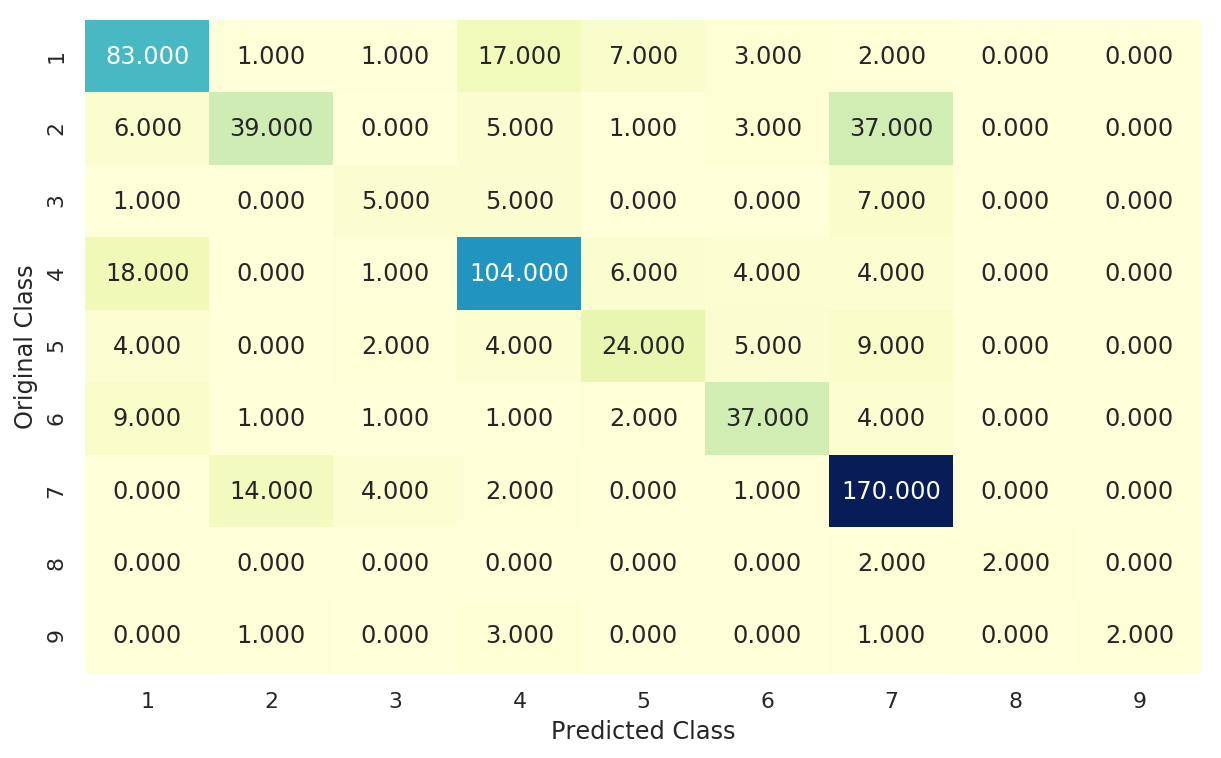

-------------------- Precision matrix (Columm Sum=1) --------------------


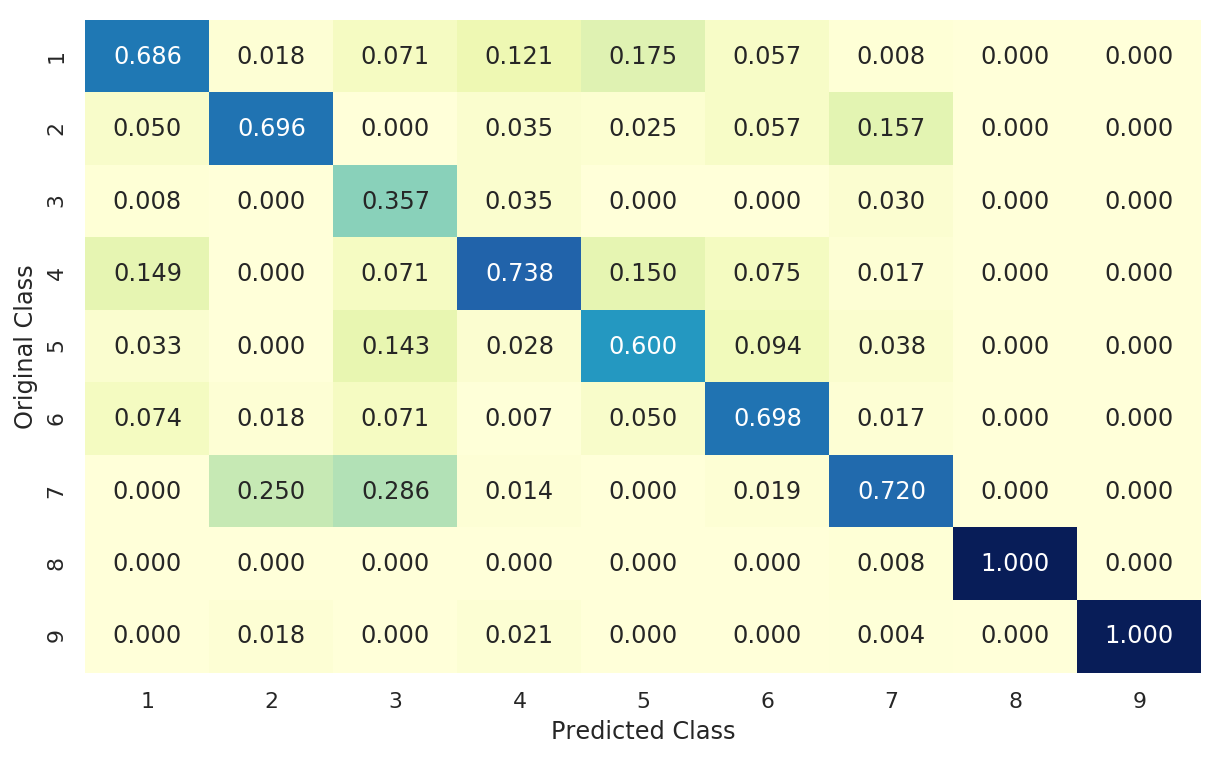

-------------------- Recall matrix (Row sum=1) --------------------


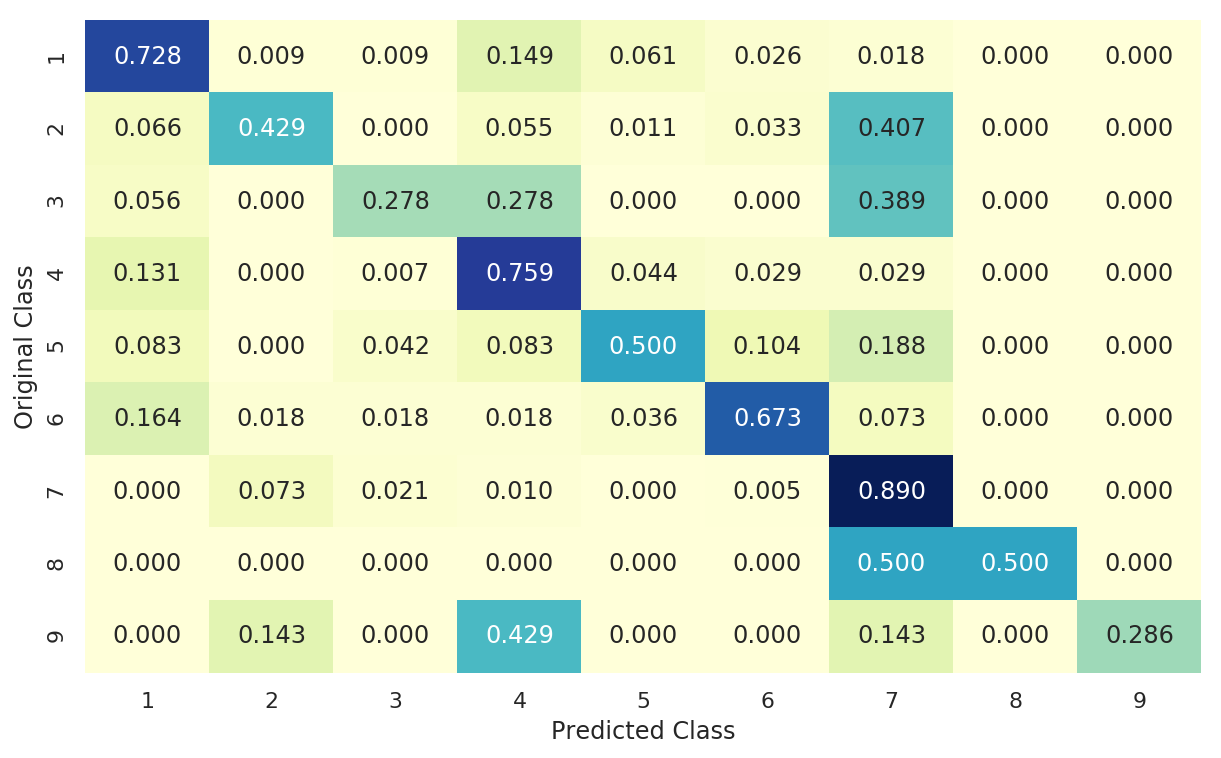

In [160]:
print("The Test log loss is:",log_loss(y_test, pred))
pred_y = np.argmax(pred, axis=1) + 1
print("Number of mis-classified points :", np.count_nonzero((pred_y- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, pred_y)

<table style="width:60%">
  <tr>
    <th>Algorithm</th>  
    <th>Model</th>
    <th>Percent of misclassified point</th> 
    <th>Dimension</th>
    <th>Test Logloss</th>
  </tr>
  <tr>
    <td> SGDClassifier with log loss </td>
    <td>OneHotEncoded Gene, Variation + 1gram TFIDF + 1,2gram CountVectorizer of text</td>
    <td>NA</td> 
    <td>785767</td>
    <td>1.1492</td>
  </tr>
    
  <tr>
    <td> Logistic Regression Fine tuned </td>
    <td>Same as model 1</td>
    <td>35.187%</td> 
    <td>785767</td>
    <td>1.0912</td>
  </tr>
  
   <tr>
    <td> Logistic Regression Fine Tuned </td>
    <td>OneHotEncoding of Gene, Variation, 1,2,3gram TFIDF of 20000 features </td>
    <td>30.075%</td> 
    <td>22182</td>
    <td>0.8864</td>
  </tr>
  
  <tr>
    <td> Fine tuned Logistic Regression + Fine tuned RandomForest </td>
    <td>Manual average ensemble of model2 + fine tuned RandomForest of 
        response coding of gene, variation, text + binary countvectorizer
        of text.
    </td>
    <td>29.924%</td> 
    <td>NA</td>
    <td>0.8736</td>
  </tr>
  
</table>
